## I) Fully Connected (Dense) Autoencoder for ECG's

### Importing Modules

In [17]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import nibabel as nib
import re
import numpy as np
import xml.dom.minidom as minidom
import cv2
from skimage.transform import resize

In [18]:
import os
import tempfile
import shutil

import monai
from monai.data import ImageDataset
from monai.transforms import Compose, EnsureChannelFirst, RandAdjustContrast, Spacing
from monai.config import print_config

print_config()

MONAI version: 0.8.1
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1+cu111
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Import utils.py
from utils.utils import loadECG
from utils.utils import median_filter

### CPU OR GPU Selection

In [4]:
device = "cpu"

In [5]:
device

'cpu'

- This command will return a boolean (True/False) letting you know if a <b>GPU</b> is available.

In [6]:
import torch
use_cuda = torch.cuda.is_available()

In [7]:
use_cuda

True

In [8]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8005
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3090
__CUDA Device Total Memory [GB]: 25.43812608


### Selecting a GPU to use

In [9]:
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


- Code if we want to use <b>specific GPU</b>:

In [10]:
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda:0


## Load ECG Data

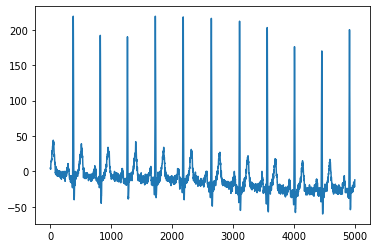

In [5]:
for root, dirs, files in os.walk("/UKBB/ecg/16xxxxx/1649846/"):
    for file in files:
        
        # LoadECG a xml smaple ECG to plot
        ecg_sample = loadECG(os.path.join(root, file))

plt.plot(ecg_sample)       

We can see here an ECG signal sample. The max value of the signal is approximately 210, while the minimum -50. Therefore, as a pre-processing step we are going to Normalise our ECG data, so that the ECG signals that we are going to feed the model with, would have amplitude between 0 and 1.

In [6]:
ecg_xml_path_test = "/UKBB/ecg/"
regex_ecg = re.compile(r'2_0')

# Find all files that match the pattern
matching_files = []
for root, dirs, files in os.walk(ecg_xml_path_test):
    for file in files:
        if regex_ecg.search(file):
            matching_files.append(os.path.join(root, file))

# Sort the files by their names
matching_files.sort()

In [7]:
ecgs = []

number_of_files = 4309 #10000
i = 0
break_outer_loop = False

# Process the sorted files
for i, file in enumerate(matching_files[:number_of_files]):
    
    i = i + 1
    print('Found a new ECG xml signal in the path: ', os.path.join(root, file))

    # LoadECG xml files
    ecg = loadECG(os.path.join(root, file))

    # Select the first 600 samples from the full 5000 ECG
    ecg = ecg[0:600]

    # Normalization
    ecg = (ecg - ecg.min()) / (ecg.max() - ecg.min() + 1e-4)

    ecgs.append(ecg)


    if (i == number_of_files):
        break_outer_loop = True
        break

    if break_outer_loop:
        break

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000195/1000195_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000384/1000384_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000500/1000500_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000511/1000511_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000771/1000771_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000846/1000846_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1000874/1000874_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1001009/1001009_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1001234/1001234_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1001333/1001333_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1001553/1001553_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011528/1011528_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011609/1011609_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011612/1011612_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011625/1011625_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011726/1011726_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1011799/1011799_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1012140/1012140_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1012285/1012285_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1012321/1012321_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1012355/1012355_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1012388/1012388_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023113/1023113_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023154/1023154_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023168/1023168_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023273/1023273_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023363/1023363_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023498/1023498_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023555/1023555_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023753/1023753_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1023865/1023865_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1024030/1024030_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1024069/1024069_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1035888/1035888_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1035901/1035901_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1035947/1035947_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036098/1036098_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036218/1036218_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036262/1036262_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036401/1036401_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036514/1036514_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036596/1036596_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036687/1036687_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1036952/1036952_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1048073/1048073_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1048081/1048081_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1048563/1048563_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1048779/1048779_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1048912/1048912_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049088/1049088_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049100/1049100_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049148/1049148_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049267/1049267_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049338/1049338_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1049342/1049342_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060366/1060366_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060560/1060560_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060591/1060591_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060617/1060617_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060621/1060621_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060793/1060793_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060867/1060867_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1060938/1060938_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1061149/1061149_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1061195/1061195_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1061339/1061339_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1070773/1070773_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1070823/1070823_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1070955/1070955_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1071175/1071175_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1071455/1071455_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1071764/1071764_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1071909/1071909_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1071950/1071950_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1072020/1072020_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1072299/1072299_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1072384/1072384_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1083284/1083284_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1083313/1083313_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1083805/1083805_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084406/1084406_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084510/1084510_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084537/1084537_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084566/1084566_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084595/1084595_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084667/1084667_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1084807/1084807_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1085087/1085087_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094213/1094213_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094226/1094226_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094287/1094287_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094315/1094315_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094442/1094442_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094477/1094477_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094559/1094559_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094676/1094676_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1094869/1094869_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1095036/1095036_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/10xxxxx/1095098/1095098_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1107554/1107554_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1107661/1107661_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1107858/1107858_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1107903/1107903_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108139/1108139_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108348/1108348_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108372/1108372_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108538/1108538_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108542/1108542_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108613/1108613_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1108755/1108755_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117079/1117079_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117090/1117090_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117168/1117168_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117252/1117252_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117295/1117295_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117324/1117324_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117363/1117363_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117425/1117425_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117450/1117450_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117517/1117517_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1117657/1117657_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1127972/1127972_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1127994/1127994_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128005/1128005_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128014/1128014_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128038/1128038_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128247/1128247_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128317/1128317_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128392/1128392_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128583/1128583_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1128945/1128945_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1129089/1129089_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1139841/1139841_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1139889/1139889_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1139927/1139927_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1139933/1139933_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140004/1140004_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140095/1140095_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140175/1140175_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140215/1140215_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140387/1140387_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140403/1140403_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1140430/1140430_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1150499/1150499_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1150518/1150518_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1150520/1150520_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151022/1151022_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151198/1151198_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151200/1151200_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151233/1151233_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151334/1151334_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151375/1151375_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151482/1151482_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1151677/1151677_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1161247/1161247_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1161628/1161628_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1161666/1161666_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1161999/1161999_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1162161/1162161_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1162713/1162713_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1162820/1162820_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1162994/1162994_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1163057/1163057_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1163389/1163389_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1163451/1163451_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1173572/1173572_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1173750/1173750_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1173803/1173803_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1173979/1173979_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1173985/1173985_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174011/1174011_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174121/1174121_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174130/1174130_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174312/1174312_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174431/1174431_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1174589/1174589_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184326/1184326_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184582/1184582_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184627/1184627_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184701/1184701_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184925/1184925_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1184983/1184983_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1185032/1185032_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1185113/1185113_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1185126/1185126_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1185154/1185154_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1185237/1185237_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1194987/1194987_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1194999/1194999_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195033/1195033_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195121/1195121_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195155/1195155_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195169/1195169_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195261/1195261_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195350/1195350_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195487/1195487_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195706/1195706_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/11xxxxx/1195804/1195804_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1204952/1204952_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205092/1205092_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205267/1205267_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205342/1205342_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205396/1205396_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205641/1205641_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205831/1205831_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205915/1205915_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1205939/1205939_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1206024/1206024_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1206177/1206177_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216012/1216012_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216098/1216098_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216184/1216184_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216447/1216447_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216529/1216529_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216774/1216774_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216788/1216788_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216835/1216835_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1216863/1216863_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1217072/1217072_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1217155/1217155_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1228801/1228801_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1228816/1228816_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1228885/1228885_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229105/1229105_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229196/1229196_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229347/1229347_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229390/1229390_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229609/1229609_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229698/1229698_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229841/1229841_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1229875/1229875_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1242329/1242329_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1242449/1242449_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1242797/1242797_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1242831/1242831_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1242922/1242922_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243120/1243120_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243141/1243141_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243260/1243260_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243492/1243492_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243535/1243535_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1243563/1243563_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253534/1253534_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253541/1253541_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253852/1253852_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253873/1253873_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253940/1253940_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1253982/1253982_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1254056/1254056_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1254339/1254339_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1254442/1254442_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1254533/1254533_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1254586/1254586_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1264984/1264984_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1265114/1265114_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1265138/1265138_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1265457/1265457_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1265807/1265807_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1265893/1265893_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1266147/1266147_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1266366/1266366_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1266465/1266465_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1266494/1266494_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1266688/1266688_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276475/1276475_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276567/1276567_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276637/1276637_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276711/1276711_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276733/1276733_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1276759/1276759_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1277003/1277003_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1277021/1277021_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1277030/1277030_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1277148/1277148_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1277236/1277236_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1286858/1286858_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1286885/1286885_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1286917/1286917_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1286921/1286921_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1286930/1286930_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1287245/1287245_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1287608/1287608_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1287709/1287709_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1287736/1287736_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1288189/1288189_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1288701/1288701_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298604/1298604_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298637/1298637_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298652/1298652_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298748/1298748_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298843/1298843_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298878/1298878_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298884/1298884_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1298945/1298945_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1299075/1299075_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1299137/1299137_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/12xxxxx/1299429/1299429_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1310723/1310723_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1310779/1310779_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1310805/1310805_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1310853/1310853_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311376/1311376_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311382/1311382_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311397/1311397_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311409/1311409_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311412/1311412_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311569/1311569_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1311738/1311738_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322599/1322599_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322638/1322638_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322728/1322728_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322752/1322752_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322766/1322766_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1322988/1322988_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1323024/1323024_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1323203/1323203_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1323581/1323581_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1323713/1323713_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1323900/1323900_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335048/1335048_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335059/1335059_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335238/1335238_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335325/1335325_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335575/1335575_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335593/1335593_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335679/1335679_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335757/1335757_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335804/1335804_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335828/1335828_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1335873/1335873_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1345979/1345979_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346050/1346050_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346160/1346160_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346191/1346191_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346218/1346218_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346311/1346311_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346327/1346327_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346359/1346359_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346553/1346553_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346699/1346699_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1346755/1346755_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357085/1357085_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357102/1357102_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357281/1357281_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357340/1357340_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357376/1357376_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357471/1357471_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357498/1357498_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357530/1357530_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357622/1357622_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357800/1357800_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1357920/1357920_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371495/1371495_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371620/1371620_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371675/1371675_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371735/1371735_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371782/1371782_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1371826/1371826_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1372048/1372048_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1372130/1372130_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1372229/1372229_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1372238/1372238_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1372336/1372336_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1382998/1382998_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383092/1383092_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383186/1383186_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383314/1383314_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383410/1383410_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383523/1383523_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383564/1383564_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383656/1383656_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383719/1383719_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1383899/1383899_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1384397/1384397_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1394371/1394371_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1394413/1394413_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1394647/1394647_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1394919/1394919_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1394924/1394924_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395057/1395057_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395084/1395084_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395167/1395167_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395200/1395200_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395294/1395294_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/13xxxxx/1395362/1395362_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403547/1403547_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403585/1403585_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403662/1403662_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403776/1403776_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403939/1403939_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403960/1403960_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1403978/1403978_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1404016/1404016_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1404425/1404425_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1404467/1404467_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1404530/1404530_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1413825/1413825_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414307/1414307_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414341/1414341_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414389/1414389_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414435/1414435_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414476/1414476_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414531/1414531_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414832/1414832_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414921/1414921_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1414955/1414955_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1415257/1415257_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1427684/1427684_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1427729/1427729_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1427742/1427742_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1427975/1427975_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428208/1428208_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428240/1428240_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428251/1428251_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428427/1428427_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428433/1428433_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428617/1428617_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1428980/1428980_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440172/1440172_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440209/1440209_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440338/1440338_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440437/1440437_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440516/1440516_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440590/1440590_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440662/1440662_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440708/1440708_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440797/1440797_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440826/1440826_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1440831/1440831_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1451746/1451746_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1451995/1451995_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452039/1452039_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452150/1452150_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452167/1452167_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452200/1452200_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452435/1452435_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452599/1452599_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452677/1452677_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452696/1452696_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1452885/1452885_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462295/1462295_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462471/1462471_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462615/1462615_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462622/1462622_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462639/1462639_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462691/1462691_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462811/1462811_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462859/1462859_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462894/1462894_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1462934/1462934_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1463009/1463009_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1471796/1471796_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1471865/1471865_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1471894/1471894_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1471918/1471918_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472087/1472087_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472276/1472276_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472395/1472395_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472494/1472494_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472762/1472762_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1472953/1472953_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1473000/1473000_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481737/1481737_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481773/1481773_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481823/1481823_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481832/1481832_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481847/1481847_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481864/1481864_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1481885/1481885_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1482012/1482012_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1482234/1482234_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1482256/1482256_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1482327/1482327_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1491759/1491759_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1491772/1491772_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1491954/1491954_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1491987/1491987_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1491999/1491999_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492196/1492196_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492217/1492217_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492269/1492269_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492510/1492510_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492671/1492671_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/14xxxxx/1492889/1492889_20205_2_0.xml
Found a new ECG xml s

Found a new ECG xml signal in the path:  /UKBB/ecg/15xxxxx/1503632/1503632_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/15xxxxx/1503849/1503849_20205_2_0.xml
Found a new ECG xml signal in the path:  /UKBB/ecg/15xxxxx/1503852/1503852_20205_2_0.xml


In [8]:
# ecg_xml_path_test = "/UKBB/ecg/"
# regex_ecg = re.compile(r'2_0')

# ecgs = []

# number_of_files = 5000
# i = 0
# break_outer_loop = False

# for root, dirs, files in os.walk(ecg_xml_path_test):
#     for file in files:
#         if regex_ecg.search(file):
#             i = i + 1
#             print('Found a new ECG xml signal in the path: ', os.path.join(root, file))

#             # LoadECG xml files
#             ecg = loadECG(os.path.join(root, file))

#             # Select the first 600 samples from the full 5000 ECG
#             ecg = ecg[0:600]

#             # Normalization
#             ecg = (ecg - ecg.min()) / (ecg.max() - ecg.min() + 1e-4)

#             ecgs.append(ecg)


#             if (i == number_of_files):
#                 break_outer_loop = True
#                 break
                
#             if break_outer_loop:
#                 break
#         if break_outer_loop:
#             break
#     if break_outer_loop:
#         break

In [9]:
len(ecgs)

4309

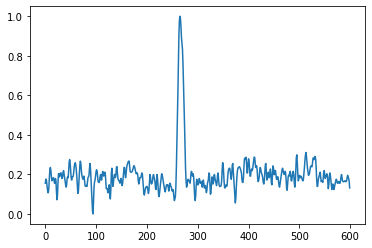

In [10]:
plt.plot(ecgs[70])

After Normalization we can see that the ECG signal has amplitude <b>between 0 and 1</b>.

In [11]:
ecg_data = np.array([np.float32(x) for x in ecgs])

In [12]:
type(ecg_data)

numpy.ndarray

## Denoise ECG signals

In [15]:
signal_den = median_filter(ecgs[70], 7)

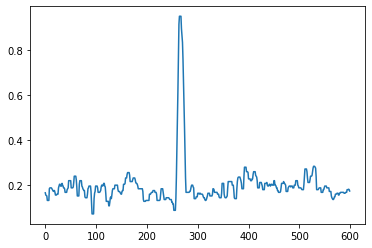

In [16]:
plt.plot(signal_den)

### Plot Normalised and Denoised signals

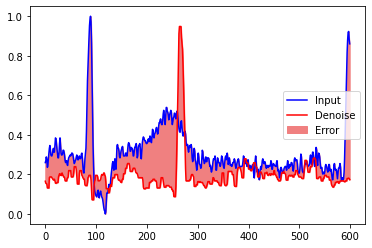

In [23]:
plt.plot(ecgs[10], 'b')
plt.plot(signal_den, 'r')
plt.fill_between(np.arange(600), signal_den, ecgs[10], color='lightcoral')
plt.legend(labels=["Input", "Denoise", "Error"])
plt.show()

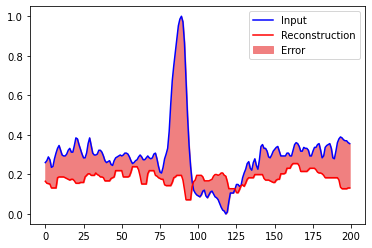

In [24]:
# Select a small time period to plot
start_time = 0
end_time = 200

ecg = ecgs[10]

# Plot the input and reconstruction data for the selected time period
plt.plot(ecg[start_time:end_time], 'b')
plt.plot(signal_den[start_time:end_time], 'r')

# Fill in the area between the input and reconstruction curves for the selected time period
plt.fill_between(np.arange(start_time, end_time), 
                 signal_den[start_time:end_time], 
                 ecg[start_time:end_time], 
                 color='lightcoral')

# Add a legend and show the plot
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [25]:
filtered_ecgs = []

for signal in ecgs:
    filtered_signal = median_filter(signal, 7)
    filtered_ecgs.append(filtered_signal)
    
ecgs = filtered_ecgs

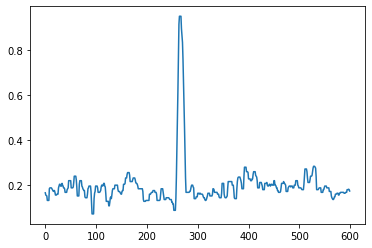

In [26]:
plt.plot(ecgs[70])

### Train and Validation Data Split 

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_data, test_data = train_test_split(ecg_data, test_size=0.2, random_state=21)

### Tensorflow Keras ECG Reconstruction

In [20]:
class ecg_autoencoder(Model):
    def __init__(self):
        super(ecg_autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                                        layers.Dense(256, activation='relu'),
                                        layers.Dense(128, activation='relu'),
                                        layers.Dense(64, activation='relu'),
                                        layers.Dense(32, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
                                        layers.Dense(64, activation='relu'),
                                        layers.Dense(128, activation='relu'),
                                        layers.Dense(256, activation='relu'),
                                        layers.Dense(600, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
autoencoder = ecg_autoencoder()

In [22]:
autoencoder.compile(optimizer='adam', loss='mae')

In [23]:
history = autoencoder.fit(train_data, train_data, 
          epochs=600, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/600
14/14 [==============================] - 1s 26ms/step - loss: 0.2476 - val_loss: 0.2016
Epoch 2/600
14/14 [==============================] - 0s 5ms/step - loss: 0.1848 - val_loss: 0.1801
Epoch 3/600
14/14 [==============================] - 0s 6ms/step - loss: 0.1754 - val_loss: 0.1705
Epoch 4/600
14/14 [==============================] - 0s 6ms/step - loss: 0.1621 - val_loss: 0.1392
Epoch 5/600
14/14 [==============================] - 0s 6ms/step - loss: 0.1114 - val_loss: 0.0970
Epoch 6/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0968 - val_loss: 0.0926
Epoch 7/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0907 - val_loss: 0.0876
Epoch 8/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0878 - val_loss: 0.0858
Epoch 9/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0859 - val_loss: 0.0841
Epoch 10/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0833 - val_loss: 0.0824
Epoch 11

14/14 [==============================] - 0s 5ms/step - loss: 0.0581 - val_loss: 0.0594
Epoch 84/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0580 - val_loss: 0.0593
Epoch 85/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0577 - val_loss: 0.0594
Epoch 86/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0579 - val_loss: 0.0591
Epoch 87/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0575 - val_loss: 0.0583
Epoch 88/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0569 - val_loss: 0.0583
Epoch 89/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0568 - val_loss: 0.0583
Epoch 90/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0567 - val_loss: 0.0591
Epoch 91/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0566 - val_loss: 0.0575
Epoch 92/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0559 - val_loss: 0.0571
Epoch 93/600


14/14 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0477
Epoch 246/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0472
Epoch 247/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.0471
Epoch 248/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.0472
Epoch 249/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0472
Epoch 250/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0470
Epoch 251/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.0473
Epoch 252/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.0473
Epoch 253/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.0470
Epoch 254/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0470
Epoc

14/14 [==============================] - 0s 6ms/step - loss: 0.0413 - val_loss: 0.0442
Epoch 408/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0442
Epoch 409/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0406 - val_loss: 0.0435
Epoch 410/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0435
Epoch 411/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0435
Epoch 412/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0435
Epoch 413/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0436
Epoch 414/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.0438
Epoch 415/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0435
Epoch 416/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0436
Epoc

14/14 [==============================] - 0s 6ms/step - loss: 0.0380 - val_loss: 0.0415
Epoch 570/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0416
Epoch 571/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0380 - val_loss: 0.0415
Epoch 572/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.0412
Epoch 573/600
14/14 [==============================] - 0s 7ms/step - loss: 0.0377 - val_loss: 0.0413
Epoch 574/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0378 - val_loss: 0.0412
Epoch 575/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0412
Epoch 576/600
14/14 [==============================] - 0s 7ms/step - loss: 0.0377 - val_loss: 0.0411
Epoch 577/600
14/14 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0412
Epoch 578/600
14/14 [==============================] - 0s 5ms/step - loss: 0.0377 - val_loss: 0.0413
Epoc

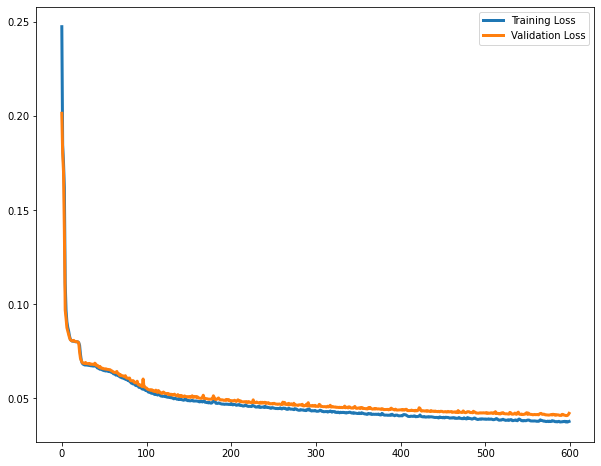

In [24]:
plt.figure(figsize=(10,8))
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

In [25]:
encoded_data = autoencoder.encoder(ecg_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

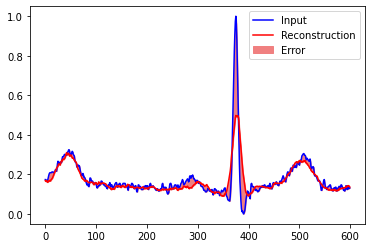

In [26]:
plt.plot(ecg_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(600), decoded_data[0], ecg_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

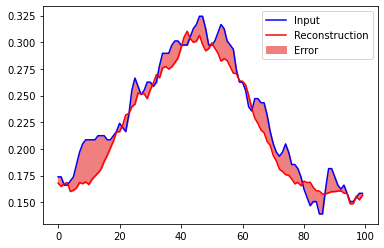

In [27]:
# Select a small time period to plot
start_time = 0
end_time = 100

# Plot the input and reconstruction data for the selected time period
plt.plot(ecg_data[0, start_time:end_time], 'b')
plt.plot(decoded_data[0, start_time:end_time], 'r')

# Fill in the area between the input and reconstruction curves for the selected time period
plt.fill_between(np.arange(start_time, end_time), 
                 decoded_data[0, start_time:end_time], 
                 ecg_data[0, start_time:end_time], 
                 color='lightcoral')

# Add a legend and show the plot
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### PyTorch ECG Reconstruction

In [29]:
import torch
import torch.nn as nn

class EcgAutoencoder(nn.Module):
    def __init__(self):
        super(EcgAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(600, 512),# nn.Linear(600, 256),
            nn.ReLU(),
            nn.Linear(512, 400),# nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(400, 300),# nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(300, 256),# nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 300),# nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(300, 400),# nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(400, 512),# nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(512, 600),# nn.Linear(256, 600),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [47]:
ecg_autoencoder = EcgAutoencoder()

### Model Parameters

In [48]:
# Iterate over each module in the model and print the number of parameters

print("Number of parameters for each layer of my model: \n-------------------------------")
for name, module in ecg_autoencoder.named_modules():
    if isinstance(module, torch.nn.Conv1d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.ConvTranspose1d):
        num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"{name} - {num_params}")


Number of parameters for each layer of my model: 
-------------------------------
encoder.0 - 307712
encoder.2 - 205200
encoder.4 - 120300
encoder.6 - 77056
decoder.0 - 77100
decoder.2 - 120400
decoder.4 - 205312
decoder.6 - 307800


In [49]:
pytorch_total_params = sum(p.numel() for p in ecg_autoencoder.parameters() if p.requires_grad)
print("Total number of parameters for my model: ", pytorch_total_params)

Total number of parameters for my model:  1420880


### Pre-Train for ECG's

In [50]:
import torch.optim as optim

encoded_ecgs = []

# Declare the batch size
batch_size = 512 # 32 to acquire the encoded_ecgs for the latent space representation

# Convert the training data to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)

# Initialize the model and optimizer
optimizer = optim.Adam(ecg_autoencoder.parameters(), lr=0.001)

train_losses = []

# Define the loss function
loss_fn = nn.L1Loss()

# Train the model
for epoch in range(1500):
    # Set the model to train mode
    ecg_autoencoder.train()
    
    # Loop over the batches in the training data
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Pass the batch through the model
        encoded_ecg, output = ecg_autoencoder(batch)
        
        if (epoch == 1499):
            encoded_ecgs.append(encoded_ecg)
        
        # Calculate the loss
        loss = loss_fn(output, batch)
        
        train_losses.append(loss)
        
        # Backpropagate the loss and update the weights
        loss.backward()
        optimizer.step()
        
    print("The ECG Loss for the ", epoch," epoch is: ", loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


The ECG Loss for the  0  epoch is:  tensor(0.0793, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1  epoch is:  tensor(0.0788, grad_fn=<L1LossBackward0>)
The ECG Loss for the  2  epoch is:  tensor(0.0781, grad_fn=<L1LossBackward0>)
The ECG Loss for the  3  epoch is:  tensor(0.0791, grad_fn=<L1LossBackward0>)
The ECG Loss for the  4  epoch is:  tensor(0.0782, grad_fn=<L1LossBackward0>)
The ECG Loss for the  5  epoch is:  tensor(0.0781, grad_fn=<L1LossBackward0>)
The ECG Loss for the  6  epoch is:  tensor(0.0780, grad_fn=<L1LossBackward0>)
The ECG Loss for the  7  epoch is:  tensor(0.0778, grad_fn=<L1LossBackward0>)
The ECG Loss for the  8  epoch is:  tensor(0.0777, grad_fn=<L1LossBackward0>)
The ECG Loss for the  9  epoch is:  tensor(0.0776, grad_fn=<L1LossBackward0>)
The ECG Loss for the  10  epoch is:  tensor(0.0776, grad_fn=<L1LossBackward0>)
The ECG Loss for the  11  epoch is:  tensor(0.0776, grad_fn=<L1LossBackward0>)
The ECG Loss for the  12  epoch is:  tensor(0.0776, grad_fn=<L

The ECG Loss for the  104  epoch is:  tensor(0.0650, grad_fn=<L1LossBackward0>)
The ECG Loss for the  105  epoch is:  tensor(0.0652, grad_fn=<L1LossBackward0>)
The ECG Loss for the  106  epoch is:  tensor(0.0635, grad_fn=<L1LossBackward0>)
The ECG Loss for the  107  epoch is:  tensor(0.0632, grad_fn=<L1LossBackward0>)
The ECG Loss for the  108  epoch is:  tensor(0.0628, grad_fn=<L1LossBackward0>)
The ECG Loss for the  109  epoch is:  tensor(0.0629, grad_fn=<L1LossBackward0>)
The ECG Loss for the  110  epoch is:  tensor(0.0628, grad_fn=<L1LossBackward0>)
The ECG Loss for the  111  epoch is:  tensor(0.0626, grad_fn=<L1LossBackward0>)
The ECG Loss for the  112  epoch is:  tensor(0.0625, grad_fn=<L1LossBackward0>)
The ECG Loss for the  113  epoch is:  tensor(0.0627, grad_fn=<L1LossBackward0>)
The ECG Loss for the  114  epoch is:  tensor(0.0617, grad_fn=<L1LossBackward0>)
The ECG Loss for the  115  epoch is:  tensor(0.0612, grad_fn=<L1LossBackward0>)
The ECG Loss for the  116  epoch is:  te

The ECG Loss for the  207  epoch is:  tensor(0.0459, grad_fn=<L1LossBackward0>)
The ECG Loss for the  208  epoch is:  tensor(0.0455, grad_fn=<L1LossBackward0>)
The ECG Loss for the  209  epoch is:  tensor(0.0452, grad_fn=<L1LossBackward0>)
The ECG Loss for the  210  epoch is:  tensor(0.0451, grad_fn=<L1LossBackward0>)
The ECG Loss for the  211  epoch is:  tensor(0.0448, grad_fn=<L1LossBackward0>)
The ECG Loss for the  212  epoch is:  tensor(0.0445, grad_fn=<L1LossBackward0>)
The ECG Loss for the  213  epoch is:  tensor(0.0439, grad_fn=<L1LossBackward0>)
The ECG Loss for the  214  epoch is:  tensor(0.0441, grad_fn=<L1LossBackward0>)
The ECG Loss for the  215  epoch is:  tensor(0.0438, grad_fn=<L1LossBackward0>)
The ECG Loss for the  216  epoch is:  tensor(0.0439, grad_fn=<L1LossBackward0>)
The ECG Loss for the  217  epoch is:  tensor(0.0436, grad_fn=<L1LossBackward0>)
The ECG Loss for the  218  epoch is:  tensor(0.0439, grad_fn=<L1LossBackward0>)
The ECG Loss for the  219  epoch is:  te

The ECG Loss for the  310  epoch is:  tensor(0.0407, grad_fn=<L1LossBackward0>)
The ECG Loss for the  311  epoch is:  tensor(0.0382, grad_fn=<L1LossBackward0>)
The ECG Loss for the  312  epoch is:  tensor(0.0374, grad_fn=<L1LossBackward0>)
The ECG Loss for the  313  epoch is:  tensor(0.0372, grad_fn=<L1LossBackward0>)
The ECG Loss for the  314  epoch is:  tensor(0.0369, grad_fn=<L1LossBackward0>)
The ECG Loss for the  315  epoch is:  tensor(0.0369, grad_fn=<L1LossBackward0>)
The ECG Loss for the  316  epoch is:  tensor(0.0362, grad_fn=<L1LossBackward0>)
The ECG Loss for the  317  epoch is:  tensor(0.0371, grad_fn=<L1LossBackward0>)
The ECG Loss for the  318  epoch is:  tensor(0.0364, grad_fn=<L1LossBackward0>)
The ECG Loss for the  319  epoch is:  tensor(0.0367, grad_fn=<L1LossBackward0>)
The ECG Loss for the  320  epoch is:  tensor(0.0366, grad_fn=<L1LossBackward0>)
The ECG Loss for the  321  epoch is:  tensor(0.0364, grad_fn=<L1LossBackward0>)
The ECG Loss for the  322  epoch is:  te

The ECG Loss for the  413  epoch is:  tensor(0.0357, grad_fn=<L1LossBackward0>)
The ECG Loss for the  414  epoch is:  tensor(0.0364, grad_fn=<L1LossBackward0>)
The ECG Loss for the  415  epoch is:  tensor(0.0359, grad_fn=<L1LossBackward0>)
The ECG Loss for the  416  epoch is:  tensor(0.0348, grad_fn=<L1LossBackward0>)
The ECG Loss for the  417  epoch is:  tensor(0.0346, grad_fn=<L1LossBackward0>)
The ECG Loss for the  418  epoch is:  tensor(0.0344, grad_fn=<L1LossBackward0>)
The ECG Loss for the  419  epoch is:  tensor(0.0331, grad_fn=<L1LossBackward0>)
The ECG Loss for the  420  epoch is:  tensor(0.0330, grad_fn=<L1LossBackward0>)
The ECG Loss for the  421  epoch is:  tensor(0.0331, grad_fn=<L1LossBackward0>)
The ECG Loss for the  422  epoch is:  tensor(0.0339, grad_fn=<L1LossBackward0>)
The ECG Loss for the  423  epoch is:  tensor(0.0341, grad_fn=<L1LossBackward0>)
The ECG Loss for the  424  epoch is:  tensor(0.0353, grad_fn=<L1LossBackward0>)
The ECG Loss for the  425  epoch is:  te

The ECG Loss for the  516  epoch is:  tensor(0.0340, grad_fn=<L1LossBackward0>)
The ECG Loss for the  517  epoch is:  tensor(0.0345, grad_fn=<L1LossBackward0>)
The ECG Loss for the  518  epoch is:  tensor(0.0344, grad_fn=<L1LossBackward0>)
The ECG Loss for the  519  epoch is:  tensor(0.0345, grad_fn=<L1LossBackward0>)
The ECG Loss for the  520  epoch is:  tensor(0.0361, grad_fn=<L1LossBackward0>)
The ECG Loss for the  521  epoch is:  tensor(0.0392, grad_fn=<L1LossBackward0>)
The ECG Loss for the  522  epoch is:  tensor(0.0337, grad_fn=<L1LossBackward0>)
The ECG Loss for the  523  epoch is:  tensor(0.0333, grad_fn=<L1LossBackward0>)
The ECG Loss for the  524  epoch is:  tensor(0.0327, grad_fn=<L1LossBackward0>)
The ECG Loss for the  525  epoch is:  tensor(0.0322, grad_fn=<L1LossBackward0>)
The ECG Loss for the  526  epoch is:  tensor(0.0316, grad_fn=<L1LossBackward0>)
The ECG Loss for the  527  epoch is:  tensor(0.0320, grad_fn=<L1LossBackward0>)
The ECG Loss for the  528  epoch is:  te

The ECG Loss for the  619  epoch is:  tensor(0.0308, grad_fn=<L1LossBackward0>)
The ECG Loss for the  620  epoch is:  tensor(0.0318, grad_fn=<L1LossBackward0>)
The ECG Loss for the  621  epoch is:  tensor(0.0314, grad_fn=<L1LossBackward0>)
The ECG Loss for the  622  epoch is:  tensor(0.0309, grad_fn=<L1LossBackward0>)
The ECG Loss for the  623  epoch is:  tensor(0.0317, grad_fn=<L1LossBackward0>)
The ECG Loss for the  624  epoch is:  tensor(0.0328, grad_fn=<L1LossBackward0>)
The ECG Loss for the  625  epoch is:  tensor(0.0309, grad_fn=<L1LossBackward0>)
The ECG Loss for the  626  epoch is:  tensor(0.0314, grad_fn=<L1LossBackward0>)
The ECG Loss for the  627  epoch is:  tensor(0.0314, grad_fn=<L1LossBackward0>)
The ECG Loss for the  628  epoch is:  tensor(0.0312, grad_fn=<L1LossBackward0>)
The ECG Loss for the  629  epoch is:  tensor(0.0312, grad_fn=<L1LossBackward0>)
The ECG Loss for the  630  epoch is:  tensor(0.0317, grad_fn=<L1LossBackward0>)
The ECG Loss for the  631  epoch is:  te

The ECG Loss for the  722  epoch is:  tensor(0.0302, grad_fn=<L1LossBackward0>)
The ECG Loss for the  723  epoch is:  tensor(0.0297, grad_fn=<L1LossBackward0>)
The ECG Loss for the  724  epoch is:  tensor(0.0298, grad_fn=<L1LossBackward0>)
The ECG Loss for the  725  epoch is:  tensor(0.0294, grad_fn=<L1LossBackward0>)
The ECG Loss for the  726  epoch is:  tensor(0.0294, grad_fn=<L1LossBackward0>)
The ECG Loss for the  727  epoch is:  tensor(0.0298, grad_fn=<L1LossBackward0>)
The ECG Loss for the  728  epoch is:  tensor(0.0303, grad_fn=<L1LossBackward0>)
The ECG Loss for the  729  epoch is:  tensor(0.0328, grad_fn=<L1LossBackward0>)
The ECG Loss for the  730  epoch is:  tensor(0.0321, grad_fn=<L1LossBackward0>)
The ECG Loss for the  731  epoch is:  tensor(0.0305, grad_fn=<L1LossBackward0>)
The ECG Loss for the  732  epoch is:  tensor(0.0298, grad_fn=<L1LossBackward0>)
The ECG Loss for the  733  epoch is:  tensor(0.0305, grad_fn=<L1LossBackward0>)
The ECG Loss for the  734  epoch is:  te

The ECG Loss for the  825  epoch is:  tensor(0.0304, grad_fn=<L1LossBackward0>)
The ECG Loss for the  826  epoch is:  tensor(0.0302, grad_fn=<L1LossBackward0>)
The ECG Loss for the  827  epoch is:  tensor(0.0295, grad_fn=<L1LossBackward0>)
The ECG Loss for the  828  epoch is:  tensor(0.0315, grad_fn=<L1LossBackward0>)
The ECG Loss for the  829  epoch is:  tensor(0.0311, grad_fn=<L1LossBackward0>)
The ECG Loss for the  830  epoch is:  tensor(0.0298, grad_fn=<L1LossBackward0>)
The ECG Loss for the  831  epoch is:  tensor(0.0290, grad_fn=<L1LossBackward0>)
The ECG Loss for the  832  epoch is:  tensor(0.0299, grad_fn=<L1LossBackward0>)
The ECG Loss for the  833  epoch is:  tensor(0.0295, grad_fn=<L1LossBackward0>)
The ECG Loss for the  834  epoch is:  tensor(0.0296, grad_fn=<L1LossBackward0>)
The ECG Loss for the  835  epoch is:  tensor(0.0292, grad_fn=<L1LossBackward0>)
The ECG Loss for the  836  epoch is:  tensor(0.0293, grad_fn=<L1LossBackward0>)
The ECG Loss for the  837  epoch is:  te

The ECG Loss for the  928  epoch is:  tensor(0.0292, grad_fn=<L1LossBackward0>)
The ECG Loss for the  929  epoch is:  tensor(0.0296, grad_fn=<L1LossBackward0>)
The ECG Loss for the  930  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  931  epoch is:  tensor(0.0281, grad_fn=<L1LossBackward0>)
The ECG Loss for the  932  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  933  epoch is:  tensor(0.0274, grad_fn=<L1LossBackward0>)
The ECG Loss for the  934  epoch is:  tensor(0.0287, grad_fn=<L1LossBackward0>)
The ECG Loss for the  935  epoch is:  tensor(0.0288, grad_fn=<L1LossBackward0>)
The ECG Loss for the  936  epoch is:  tensor(0.0297, grad_fn=<L1LossBackward0>)
The ECG Loss for the  937  epoch is:  tensor(0.0293, grad_fn=<L1LossBackward0>)
The ECG Loss for the  938  epoch is:  tensor(0.0296, grad_fn=<L1LossBackward0>)
The ECG Loss for the  939  epoch is:  tensor(0.0295, grad_fn=<L1LossBackward0>)
The ECG Loss for the  940  epoch is:  te

The ECG Loss for the  1031  epoch is:  tensor(0.0286, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1032  epoch is:  tensor(0.0282, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1033  epoch is:  tensor(0.0285, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1034  epoch is:  tensor(0.0282, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1035  epoch is:  tensor(0.0274, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1036  epoch is:  tensor(0.0275, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1037  epoch is:  tensor(0.0282, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1038  epoch is:  tensor(0.0273, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1039  epoch is:  tensor(0.0269, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1040  epoch is:  tensor(0.0274, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1041  epoch is:  tensor(0.0280, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1042  epoch is:  tensor(0.0289, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1043  

The ECG Loss for the  1133  epoch is:  tensor(0.0282, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1134  epoch is:  tensor(0.0273, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1135  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1136  epoch is:  tensor(0.0283, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1137  epoch is:  tensor(0.0295, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1138  epoch is:  tensor(0.0298, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1139  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1140  epoch is:  tensor(0.0275, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1141  epoch is:  tensor(0.0272, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1142  epoch is:  tensor(0.0276, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1143  epoch is:  tensor(0.0276, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1144  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1145  

The ECG Loss for the  1235  epoch is:  tensor(0.0278, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1236  epoch is:  tensor(0.0272, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1237  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1238  epoch is:  tensor(0.0278, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1239  epoch is:  tensor(0.0272, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1240  epoch is:  tensor(0.0276, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1241  epoch is:  tensor(0.0265, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1242  epoch is:  tensor(0.0261, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1243  epoch is:  tensor(0.0262, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1244  epoch is:  tensor(0.0271, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1245  epoch is:  tensor(0.0263, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1246  epoch is:  tensor(0.0270, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1247  

The ECG Loss for the  1337  epoch is:  tensor(0.0270, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1338  epoch is:  tensor(0.0268, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1339  epoch is:  tensor(0.0279, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1340  epoch is:  tensor(0.0275, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1341  epoch is:  tensor(0.0275, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1342  epoch is:  tensor(0.0269, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1343  epoch is:  tensor(0.0272, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1344  epoch is:  tensor(0.0278, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1345  epoch is:  tensor(0.0300, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1346  epoch is:  tensor(0.0292, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1347  epoch is:  tensor(0.0293, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1348  epoch is:  tensor(0.0285, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1349  

The ECG Loss for the  1439  epoch is:  tensor(0.0267, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1440  epoch is:  tensor(0.0268, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1441  epoch is:  tensor(0.0261, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1442  epoch is:  tensor(0.0258, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1443  epoch is:  tensor(0.0262, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1444  epoch is:  tensor(0.0267, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1445  epoch is:  tensor(0.0267, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1446  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1447  epoch is:  tensor(0.0280, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1448  epoch is:  tensor(0.0281, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1449  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1450  epoch is:  tensor(0.0272, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1451  

### Save the encoded_ecgs for the Latent Representation

In [51]:
len(encoded_ecgs)

108

In [52]:
# Define the file path
file_path = 'encoded_pretrained/ecg_encoded.pth'

# Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)

In [53]:
torch.save(encoded_ecgs, file_path)

### Pre-Training Results

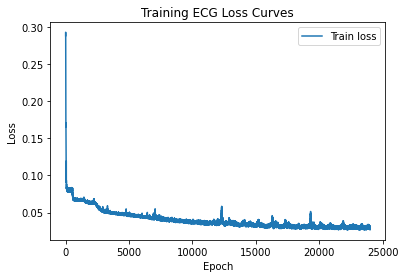

In [33]:
# plot the training
plt.plot(train_losses, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training ECG Loss Curves")
plt.legend()
plt.show()

In [34]:
#with torch.no_grad():
train_encoded_data = ecg_autoencoder.encoder(train_data)
train_decoded_data = ecg_autoencoder.decoder(train_encoded_data)

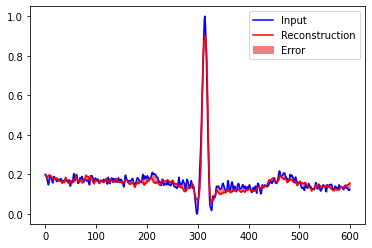

In [35]:
plt.plot(train_data[0], 'b')
plt.plot(train_decoded_data[0].detach().numpy(), 'r')
plt.fill_between(np.arange(600), train_decoded_data[0].detach().numpy(), train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Validation for ECG's

In [45]:
test_data = torch.tensor(test_data, dtype=torch.float32)

val_losses = []

for epoch in range(600):
    # Set the model to train mode
    ecg_autoencoder.eval()
    
    # Loop over the batches in the training data
    for i in range(0, len(test_data), batch_size):
        batch = test_data[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Pass the batch through the model
        output = ecg_autoencoder(batch)
        
        # Calculate the loss
        loss = loss_fn(output, batch)
        
        val_losses.append(loss)
        
        # Backpropagate the loss and update the weights
        loss.backward()
        optimizer.step()
        
    print("The ECG Loss for the ", epoch," epoch is: ", loss)

The ECG Loss for the  0  epoch is:  tensor(0.0472, grad_fn=<L1LossBackward0>)
The ECG Loss for the  1  epoch is:  tensor(0.0463, grad_fn=<L1LossBackward0>)
The ECG Loss for the  2  epoch is:  tensor(0.0447, grad_fn=<L1LossBackward0>)
The ECG Loss for the  3  epoch is:  tensor(0.0434, grad_fn=<L1LossBackward0>)
The ECG Loss for the  4  epoch is:  tensor(0.0429, grad_fn=<L1LossBackward0>)
The ECG Loss for the  5  epoch is:  tensor(0.0419, grad_fn=<L1LossBackward0>)
The ECG Loss for the  6  epoch is:  tensor(0.0409, grad_fn=<L1LossBackward0>)
The ECG Loss for the  7  epoch is:  tensor(0.0403, grad_fn=<L1LossBackward0>)
The ECG Loss for the  8  epoch is:  tensor(0.0397, grad_fn=<L1LossBackward0>)
The ECG Loss for the  9  epoch is:  tensor(0.0392, grad_fn=<L1LossBackward0>)
The ECG Loss for the  10  epoch is:  tensor(0.0387, grad_fn=<L1LossBackward0>)
The ECG Loss for the  11  epoch is:  tensor(0.0382, grad_fn=<L1LossBackward0>)
The ECG Loss for the  12  epoch is:  tensor(0.0377, grad_fn=<L

The ECG Loss for the  104  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  105  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  106  epoch is:  tensor(0.0284, grad_fn=<L1LossBackward0>)
The ECG Loss for the  107  epoch is:  tensor(0.0283, grad_fn=<L1LossBackward0>)
The ECG Loss for the  108  epoch is:  tensor(0.0282, grad_fn=<L1LossBackward0>)
The ECG Loss for the  109  epoch is:  tensor(0.0280, grad_fn=<L1LossBackward0>)
The ECG Loss for the  110  epoch is:  tensor(0.0279, grad_fn=<L1LossBackward0>)
The ECG Loss for the  111  epoch is:  tensor(0.0278, grad_fn=<L1LossBackward0>)
The ECG Loss for the  112  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  113  epoch is:  tensor(0.0277, grad_fn=<L1LossBackward0>)
The ECG Loss for the  114  epoch is:  tensor(0.0276, grad_fn=<L1LossBackward0>)
The ECG Loss for the  115  epoch is:  tensor(0.0275, grad_fn=<L1LossBackward0>)
The ECG Loss for the  116  epoch is:  te

The ECG Loss for the  208  epoch is:  tensor(0.0251, grad_fn=<L1LossBackward0>)
The ECG Loss for the  209  epoch is:  tensor(0.0250, grad_fn=<L1LossBackward0>)
The ECG Loss for the  210  epoch is:  tensor(0.0251, grad_fn=<L1LossBackward0>)
The ECG Loss for the  211  epoch is:  tensor(0.0251, grad_fn=<L1LossBackward0>)
The ECG Loss for the  212  epoch is:  tensor(0.0251, grad_fn=<L1LossBackward0>)
The ECG Loss for the  213  epoch is:  tensor(0.0250, grad_fn=<L1LossBackward0>)
The ECG Loss for the  214  epoch is:  tensor(0.0250, grad_fn=<L1LossBackward0>)
The ECG Loss for the  215  epoch is:  tensor(0.0249, grad_fn=<L1LossBackward0>)
The ECG Loss for the  216  epoch is:  tensor(0.0249, grad_fn=<L1LossBackward0>)
The ECG Loss for the  217  epoch is:  tensor(0.0249, grad_fn=<L1LossBackward0>)
The ECG Loss for the  218  epoch is:  tensor(0.0249, grad_fn=<L1LossBackward0>)
The ECG Loss for the  219  epoch is:  tensor(0.0249, grad_fn=<L1LossBackward0>)
The ECG Loss for the  220  epoch is:  te

The ECG Loss for the  312  epoch is:  tensor(0.0227, grad_fn=<L1LossBackward0>)
The ECG Loss for the  313  epoch is:  tensor(0.0228, grad_fn=<L1LossBackward0>)
The ECG Loss for the  314  epoch is:  tensor(0.0229, grad_fn=<L1LossBackward0>)
The ECG Loss for the  315  epoch is:  tensor(0.0227, grad_fn=<L1LossBackward0>)
The ECG Loss for the  316  epoch is:  tensor(0.0225, grad_fn=<L1LossBackward0>)
The ECG Loss for the  317  epoch is:  tensor(0.0225, grad_fn=<L1LossBackward0>)
The ECG Loss for the  318  epoch is:  tensor(0.0226, grad_fn=<L1LossBackward0>)
The ECG Loss for the  319  epoch is:  tensor(0.0228, grad_fn=<L1LossBackward0>)
The ECG Loss for the  320  epoch is:  tensor(0.0228, grad_fn=<L1LossBackward0>)
The ECG Loss for the  321  epoch is:  tensor(0.0228, grad_fn=<L1LossBackward0>)
The ECG Loss for the  322  epoch is:  tensor(0.0227, grad_fn=<L1LossBackward0>)
The ECG Loss for the  323  epoch is:  tensor(0.0226, grad_fn=<L1LossBackward0>)
The ECG Loss for the  324  epoch is:  te

The ECG Loss for the  416  epoch is:  tensor(0.0213, grad_fn=<L1LossBackward0>)
The ECG Loss for the  417  epoch is:  tensor(0.0213, grad_fn=<L1LossBackward0>)
The ECG Loss for the  418  epoch is:  tensor(0.0212, grad_fn=<L1LossBackward0>)
The ECG Loss for the  419  epoch is:  tensor(0.0212, grad_fn=<L1LossBackward0>)
The ECG Loss for the  420  epoch is:  tensor(0.0211, grad_fn=<L1LossBackward0>)
The ECG Loss for the  421  epoch is:  tensor(0.0212, grad_fn=<L1LossBackward0>)
The ECG Loss for the  422  epoch is:  tensor(0.0213, grad_fn=<L1LossBackward0>)
The ECG Loss for the  423  epoch is:  tensor(0.0213, grad_fn=<L1LossBackward0>)
The ECG Loss for the  424  epoch is:  tensor(0.0213, grad_fn=<L1LossBackward0>)
The ECG Loss for the  425  epoch is:  tensor(0.0212, grad_fn=<L1LossBackward0>)
The ECG Loss for the  426  epoch is:  tensor(0.0211, grad_fn=<L1LossBackward0>)
The ECG Loss for the  427  epoch is:  tensor(0.0210, grad_fn=<L1LossBackward0>)
The ECG Loss for the  428  epoch is:  te

The ECG Loss for the  520  epoch is:  tensor(0.0194, grad_fn=<L1LossBackward0>)
The ECG Loss for the  521  epoch is:  tensor(0.0197, grad_fn=<L1LossBackward0>)
The ECG Loss for the  522  epoch is:  tensor(0.0199, grad_fn=<L1LossBackward0>)
The ECG Loss for the  523  epoch is:  tensor(0.0196, grad_fn=<L1LossBackward0>)
The ECG Loss for the  524  epoch is:  tensor(0.0194, grad_fn=<L1LossBackward0>)
The ECG Loss for the  525  epoch is:  tensor(0.0198, grad_fn=<L1LossBackward0>)
The ECG Loss for the  526  epoch is:  tensor(0.0199, grad_fn=<L1LossBackward0>)
The ECG Loss for the  527  epoch is:  tensor(0.0195, grad_fn=<L1LossBackward0>)
The ECG Loss for the  528  epoch is:  tensor(0.0195, grad_fn=<L1LossBackward0>)
The ECG Loss for the  529  epoch is:  tensor(0.0198, grad_fn=<L1LossBackward0>)
The ECG Loss for the  530  epoch is:  tensor(0.0196, grad_fn=<L1LossBackward0>)
The ECG Loss for the  531  epoch is:  tensor(0.0194, grad_fn=<L1LossBackward0>)
The ECG Loss for the  532  epoch is:  te

### Validation Results for pre-Training

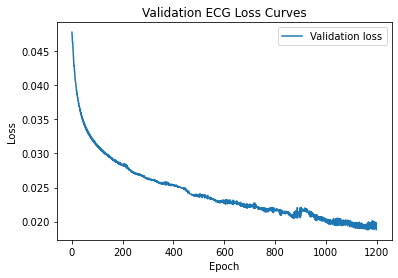

In [46]:
# plot the validation loss curves
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation ECG Loss Curves")
plt.legend()
plt.show()

In [47]:
#with torch.no_grad():
test_encoded_data = ecg_autoencoder.encoder(test_data)
test_decoded_data = ecg_autoencoder.decoder(test_encoded_data)

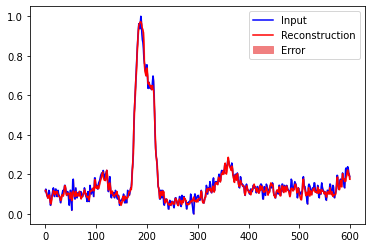

In [48]:
plt.plot(test_data[0], 'b')
plt.plot(test_decoded_data[0].detach().numpy(), 'r')
plt.fill_between(np.arange(600), test_decoded_data[0].detach().numpy(), test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### *** Save the ecg_autoencoder model parameters***

In [36]:
# # Define the file path
# file_path = 'models/ecg_model_weights.pth'

# # Check if the file exists
# if os.path.exists(file_path):
#     # Delete the file
#     os.remove(file_path)

In [37]:
# torch.save(ecg_autoencoder.state_dict(), file_path)

### Free CUDA Memory

In [54]:
import gc
del ecg_autoencoder
gc.collect()
torch.cuda.empty_cache()